# assign_dlgn-p_rgc_data_to_rgc_types

This notebooks takes in the prepared Baden2016 data (OGB-1), created in prepare_Baden2016_data.ipynb, and the prepared dLGN-p RGC data (GCaMP6f), created in prepare_dlgn-p_rgc_data.ipynb, and assigns the dLGN-p RGCs to RGC types. The assignment works with a match index (Mi) that finds, for each dLGN-p RGC the best-matching RGC type. Best-matching here means the best-correlating quality-weighted RGC type.

# TODO

- kill MeanDeconv calls
- kill /ext/ code reference?
- check if g6_assigned is used anywhere?
- maintain analysis options?
  - 'groupVClu': 'Clu', # OPTIONS: 'Group', 'Clu'
  - 'miCrit': 0, # MI-percentile criterion; set miCrit = 0 for all cells


# Qs:



# Setup

In [1]:
## Library/module setup

# Misc libs
from __future__ import print_function
import warnings

# System libs
import os
import sys

# Data libs
import h5py # HDF5 lib
import numpy as np
import pandas as pd
import scipy
import scipy.io as sio
from scipy import stats

# Plotting libs
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.gridspec as gridspec
%matplotlib inline

# Custom libs/mods
sys.path.append('../utils/') # Import path to utility functions
# sys.path.append('../ext/') # Import path to external code
import postProc as pop # Import PostProcessing module (functions: normalization, interpolation, QI etc.)

In [2]:
# Avoid large figure issues
plt.close()
import gc
gc.collect()

15

In [64]:
### Parameter setup
p = {}
p.update({
        # I/O parameters        
        'loadDir': '../../data/2P/proc/', # set load root directory        
        'saveDir': '../../data/2P/proc/', # save directory
        'fidGcamp6': 'dlgn-p_rgc_data_gcamp6fKern_7.8Hz.h5',
        'fidGcamp6Save': 'dlgn-p_rgc_assigned.mat',
        'fidOgb1Group': 'BadenEtAl_RGCs_2016_ogb1_group_ogb1Kern_7.8Hz.mat',
        'fidOgb1Clu': 'BadenEtAl_RGCs_2016_ogb1_clu_ogb1Kern_7.8Hz.mat',
#         'cmapDir': '../ext/cMaps/', # Colour map from Baden2016 
#         'cmapFid': 'cMap_igor.mat',
        
        # Set stimuli of interest & var names for dataframe accordingly
        'stim': ["chirp", "bar"], # stimulus        
        
        # Choose if analysing groups or clusters
        'groupVClu': 'Clu', # OPTIONS: 'Group', 'Clu'
        
        # Selection criterion pars
        'miCrit': 0, # MI-percentile criterion; set miCrit = 0 for all cells
        })

# Plot % Print parameters
np.set_printoptions(precision=3, suppress=True) # Mainly for plot legend to avoid overly long entries
rcParams['svg.fonttype'] = 'none' # Important for rendering text as text in .svg savefig (otherwise path)
rcParams['pdf.fonttype'] = 42 # Important for rendering text as text in .pdf savefig (otherwise path)

# Figure parameters
plt.style.use('ggplot')
sns.set_style("white") # Remove background grid
# Standard color map (reverse)
sns.set_palette('Blues_r')
# rcParams['lines.linewidth'] = 1
p

{'loadDir': '../../data/2P/proc/',
 'saveDir': '../../data/2P/proc/',
 'fidGcamp6': 'gcamp6Data_gcamp6fKern_7.8Hz.h5',
 'fidGcamp6Save': 'g6_assigned.mat',
 'fidOgb1Group': 'BadenEtAl_RGCs_2016_ogb1_group_ogb1Kern_7.8Hz.mat',
 'fidOgb1Clu': 'BadenEtAl_RGCs_2016_ogb1_clu_ogb1Kern_7.8Hz.mat',
 'stim': ['chirp', 'bar'],
 'groupVClu': 'Clu',
 'miCrit': 0}

# Load ogb1 and gcamp6 data

## Load ogb1

In [4]:
# Load ogb1-group or cluster data (.mat file)
# ogb1: dictionary
if p['groupVClu'] == 'Group':
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Group'])
    p.update({'nOgb1Groups': 32})    
elif p['groupVClu'] == 'Clu':
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Clu'])
    p.update({'nOgb1Groups': 49})    

In [5]:
# Inspect vars
if p['groupVClu'] == 'Group':
    viewData = sio.whosmat(p['loadDir']+p['fidOgb1Group'])
elif p['groupVClu'] == 'Clu':
    viewData = sio.whosmat(p['loadDir']+p['fidOgb1Clu'])    
viewData

[('chirpMean', (249, 49), 'double'),
 ('barDeconvMean', (32, 49), 'double'),
 ('barMeanDeconv', (32, 49), 'double'),
 ('barTime', (1, 32), 'double'),
 ('somaSizeIdx', (49, 1), 'int64'),
 ('barN', (1, 49), 'int64'),
 ('chirpDeconvSd', (249, 49), 'double'),
 ('barMed', (32, 49), 'double'),
 ('barDeconvSd', (32, 49), 'double'),
 ('dsIdx', (49, 1), 'int64'),
 ('chirpMeanDeconv', (249, 49), 'double'),
 ('chirpN', (1, 49), 'int64'),
 ('chirpDeconvMean', (249, 49), 'double'),
 ('chirpTime', (1, 249), 'double'),
 ('barSd', (32, 49), 'double'),
 ('chirpMed', (249, 49), 'double'),
 ('barMean', (32, 49), 'double'),
 ('chirpSd', (249, 49), 'double')]

In [6]:
## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) and get duration for each stimulus
# (.mat files seem to require storage as 2D)
for iStim in p['stim']:
    ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
    ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0] # Get stim duration
    print(ogb1[iStim+'Dur'])
    
## Add trigger times - extract flexibly later
ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
ogb1['barTrigTime'] = [1, 2]    

31.82049156626506
4.0


## Load gcamp6 cell data

In [7]:
gcamp6 = pd.read_hdf(p['loadDir']+p['fidGcamp6'], 'data')

In [8]:
print('nCells: %i' %len(gcamp6))
gcamp6.head() # show dataframe

nCells: 251


,chirpDeconvMean,chirpDeconvSd,chirpDeconvTraces,chirpMean,chirpMed,chirpQi,chirpSd,chirpTraces,date,field,...,barDeconvSd,barDeconvTraces,barMean,barMed,barQi,barSd,barTraces,dsPVal,dsVector,dsi
0,"[0.1826147157463265, 0.11674350272116026, 0.28...","[0.3020111764755086, 0.1864990656605671, 0.512...","[[0.3073475203043483, -0.04018359713302273, 0....","[-0.012871383402944633, -0.07012615340491297, ...","[-0.0055380478444985535, 0.0032716125578859598...",0.211864,"[0.08934086637531584, 0.13374222991287482, 0.1...","[[-0.0055380478444985535, -0.17303174370757296...",20160421,02,...,"[0.6968183941208237, 0.677580020890551, 0.6153...","[[0.3950545099920594, 0.5019947422866655, 0.58...","[0.0437493376413157, 0.07631438363395375, -0.0...","[0.033845851858191445, 0.08284716580885029, -0...",0.617006,"[0.21554909627370902, 0.17274266532220264, 0.2...","[[0.07111596681212387, 0.1446504901884391, 0.2...",0.065,"[0.1469716509456499, 0.08769700249239472, 0.77...",0.452632
1,"[0.39593657038333585, 0.4843333352265666, 0.36...","[0.46152671720242305, 0.3923243399983287, 0.24...","[[-0.04273116643740351, 0.29727688692307297, 0...","[-0.07832984826769979, 0.04793582675381689, -0...","[-0.27748526965760273, -0.03535813618376617, 0...",0.227458,"[0.31338387821329744, 0.2822605833385963, 0.26...","[[-0.42868383475708866, 0.2798253609700205, 0....",20160421,05,...,"[0.8711819881640622, 0.5229592659648328, 0.515...","[[1.8206340752514842, -0.8200455988821012, 0.6...","[0.1530952857720701, 0.03428491117639011, 0.06...","[0.2575283038157384, 0.07286160461778371, 0.01...",0.690928,"[0.44328456241229447, 0.24526174494883168, 0.3...","[[2.8310843003519013, -0.6956049987792707, 0.7...",0.173,"[0.45148104940828726, 0.9595072579062526, 0.45...",0.343493
2,"[0.12223668307479893, 0.09455490074015024, 0.0...","[0.06087526241430407, 0.05577819379025569, 0.0...","[[0.08963298916822729, 0.12281087181025857, 0....","[0.028360875204138748, 0.01934591665291447, 0....","[0.005773237616668786, 0.01094808481004498, 0....",0.456170,"[0.04810805066760271, 0.026399595446981967, 0....","[[0.005773237616668786, 0.038705929671366664, ...",20160421,05,...,"[0.06480781220145145, 0.055619750455282675, 0....","[[0.11028166225333942, 0.043682038215623685, -...","[0.00445197752090526, -5.2585704230299976e-05,...","[0.003976822803630835, -0.00676679862210767, 0...",0.955744,"[0.03866675782196119, 0.031322656200952106, 0....","[[0.02074391552877784, -0.00985763496432888, -...",0.112,"[0.6330595672451834, 0.6728413296799477, 0.503...",0.315990
3,"[0.24295447083704724, 0.26786940997132175, 0.2...","[0.37977102311070193, 0.2680416025567178, 0.42...","[[0.8752773988544793, 0.07200892404919765, -0....","[-0.2841945293730493, -0.2894315155464425, -0....","[0.003784784933630767, -0.11367382344340231, -...",0.440871,"[0.7391948956051511, 0.37329698969980024, 0.27...","[[0.328532088452581, -0.11367382344340231, -0....",20160421,05,...,"[0.565519659556259, 0.5720748465236802, 0.5366...","[[0.7398210458682103, 0.2736045003019318, 0.70...","[0.09007576733953289, 0.07065331760049269, 0.0...","[0.045921442873897454, 0.02154507525816632, -0...",0.717470,"[0.21284525817088915, 0.23477852709508923, 0.2...","[[0.02118436869580189, -0.14469829571710288, -...",0.000,"[0.9703966965038443, 0.7579051768806676, 0.206...",0.412893
4,"[0.511943758296649, 0.30111678946964904, 0.421...","[0.3308027361464248, 0.15309308091338586, 0.19...","[[0.6135556467327017, 0.5993081524328113, 0.45...","[0.16869152161999346, 0.02504429596007111, 0.1...","[0.2623166578287372, -0.05691833185122903, 0.2...",0.414688,"[0.41112625304333605, 0.31175320295971454, 0.2...","[[0.3605642539400666, 0.5066634265944991, 0.44...",20160421,05,...,"[0.4355420194729396, 0.2936535951575504, 0.316...","[[0.9159409669215844, 0.21473954039851464, 0.0...","[-0.007647544495034093, 0.04717657276986258, 0...","[0.013170866529535807, 0.1085817931557135, 0.0...",0.784375,"[0.32815946119485745, 0.24848200479898538, 0.2...","[[0.7392082183007923, 0.107

# Sort gcamp6 traces by QI

In [9]:
# Insert qi-sorted cell idx as new column of df for each stimulus
# Note: pandas saves row idx w argsort, so to reverse order, we need to do it on an array and reinsert it as series

for iStim in p['stim']:
    gcamp6[iStim+'QiSortIdx'] = pd.Series(np.array(gcamp6[iStim+'Qi']).argsort(axis=0)[::-1]) # [::-1] = descndg order

## Plot example GCaMP6f cells with high/low QI, both Chirp and Bar stimulus

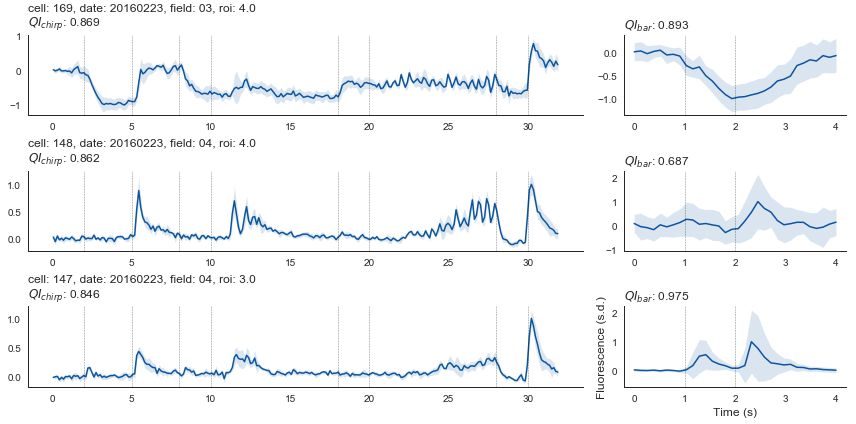

In [10]:
### Plot example gcamp6f cell responses sorted by high/low QI, both to Chirp and Bar stimulus

# Parameters
sortCrit = 'chirpQiSortIdx' # Set sort criterion. OPTIONS: chirpQiSortIdx', 'barQiSortIdx'
# sortOrder = # Ascending or descending
traceType = 'Med' # Plot mean or median; OPTIONS: 'Mean', 'Med', 'DeconvMean'
nCells = 3 # Define n cells to plot

# Figure pre-setup
rcParams['figure.figsize'] = 12, (nCells)*2 # workaround to adjust fig size
gs = gridspec.GridSpec(nCells, 2, width_ratios=[2.5,1]) # Generate nxn grid for plotting figures
sns.set_style("white") # Remove background grid

# Plot gcamp6 traces of nCells
for i in range(nCells):

    ## Left: chirp response
    plt.subplot(gs[i, 0])
    stim = p['stim'][0]

    # Avg
#     sns.tsplot(gcamp6[stim+traceType][gcamp6[sortCrit][i]].T, time=ogb1[stim+'Time'])#, label='gcamp6-mean')
    sns.lineplot(y=gcamp6[stim+traceType][gcamp6[sortCrit][i]].T, x=ogb1[stim+'Time'])#, label='gcamp6-mean')

    # Error area
    # Choose appropriate SD trace for normal vs deconvolved trace
    if (traceType == 'Mean') | (traceType == 'Med'):
        sdTrace = 'Sd'
    elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
        sdTrace = 'DeconvSd'
    plt.fill_between(ogb1[stim+'Time'],
                     gcamp6[stim+traceType][gcamp6[sortCrit][i]] + gcamp6[stim+sdTrace][gcamp6[sortCrit][i]],
                     gcamp6[stim+traceType][gcamp6[sortCrit][i]] - gcamp6[stim+sdTrace][gcamp6[sortCrit][i]],
                     alpha=0.15,
#                      edgecolor='k',
#                      facecolor='k',
#                      label='gcamp6-sd',
                    )
    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)

    plt.title("cell: {0}, date: {1}, field: {2}, roi: {3}".format(
            gcamp6.index.get_loc(gcamp6[sortCrit][i]),
            gcamp6['date'][gcamp6[sortCrit][i]],
            gcamp6['field'][gcamp6[sortCrit][i]],
            gcamp6['roi'][gcamp6[sortCrit][i]])+
              "\n$QI_{chirp}$: " + "{0}".format(
            np.round(gcamp6['chirpQi'][gcamp6[sortCrit][i]], 3)),
            loc='left', fontsize=12)
#     plt.legend()

    ###########################################################################

    ## Right: bar response
    plt.subplot(gs[i, 1])
    stim = p['stim'][1]

    # Avg
    sns.lineplot(y=gcamp6[stim+traceType][gcamp6[sortCrit][i]].T, x=ogb1[stim+'Time'])#, label='gcamp6-mean')

    # Error area
    # Choose appropriate SD trace for normal vs deconvolved trace
    if (traceType == 'Mean') | (traceType == 'Med'):
        sdTrace = 'Sd'
    elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
        sdTrace = 'DeconvSd'
    plt.fill_between(ogb1[stim+'Time'],
                     gcamp6[stim+traceType][gcamp6[sortCrit][i]] + gcamp6[stim+sdTrace][gcamp6[sortCrit][i]],
                     gcamp6[stim+traceType][gcamp6[sortCrit][i]] - gcamp6[stim+sdTrace][gcamp6[sortCrit][i]],
                     alpha=0.15,
#                      edgecolor='k',
#                      facecolor='k',
#                      label='gcamp6-sd',
                    )
    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)

    plt.title("$QI_{bar}$: " + "{0}".format(np.round(gcamp6['barQi'][gcamp6[sortCrit][i]], 3)),
              loc='left', fontsize=12)

# Figure post-setup
# sns.plt.suptitle('GCamp6 cells sorted by high/low QI\n Left: Chirp; Right: Bar', fontsize=12) # Supertitle
plt.gca().set(
    xlabel = 'Time (s)', # info: comments can be put in line here
    ylabel = 'Fluorescence (s.d.)',
    ) # axis labels
sns.despine(top = True, right = True) # Remove unwanted axis borders
plt.tight_layout()

# Correlate GCamp6 and OGB-1 data for each stimulus

## Pearson product-moment correlation coefficient

In [11]:
# Parameters
traceTypeG6 = 'DeconvMean'
traceTypeO1 = 'DeconvMean'

# Find cell-group correlations for each stimulus
for iStim in p['stim']:
    # Get correlation matrix
    r = pop.pearsonr2D(np.array(gcamp6[iStim+traceTypeG6].values.tolist()), ogb1[iStim+traceTypeO1].T)

    # Insert corrs into df -> for each cell, this will result in a list of corrs, one per cluster/group
    gcamp6[iStim+'CorrR'] = pd.Series(list(r))

## Sort cells and/or groups according to correlation

In [12]:
# Sort cells/groups by correlation for each stimulus
for iStim in p['stim']:
    # Sort groups for each cell: for each gcamp6 cell, sort ogb1 groups according to their stimulus response corr
    groupSortIdx = np.array(gcamp6[iStim+'CorrR'].values.tolist()).argsort(axis=1)[:,::-1]

    # Insert groupSortIdx into gcamp6 df -> for each cell, this is a list of groups indices sorted by corr
    gcamp6[iStim+'CorrSortIdx'] = pd.Series(list(groupSortIdx))
    
    # Sort cells: For each ogb1 group, sort gcamp6 cells according to their stimulus response correlation
    cellSortIdx = np.array(gcamp6[iStim+'CorrR'].values.tolist()).argsort(axis=0)[::-1]

    # Insert cellSortIdx into ogb1 dict -> for each ogb1-group, this is a list of cell indices sorted by corr
    ogb1[iStim+'CorrSortIdx'] = cellSortIdx

print(cellSortIdx.shape)    
print(groupSortIdx.shape)

(251, 49)
(251, 49)


## Plot distribution of correlations - max correlation value for each cell

In [13]:
## Get max corrs
for iStim in p['stim']:
    a = np.array(gcamp6[iStim+'CorrR'].values.tolist())
    b = np.array(gcamp6[iStim+'CorrSortIdx'].values.tolist())[:, 0]
    gcamp6[iStim+'MaxCorrs'] = a[np.arange(a.shape[0]), b] 

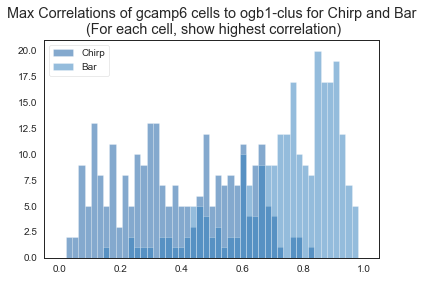

/Users/Yannik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


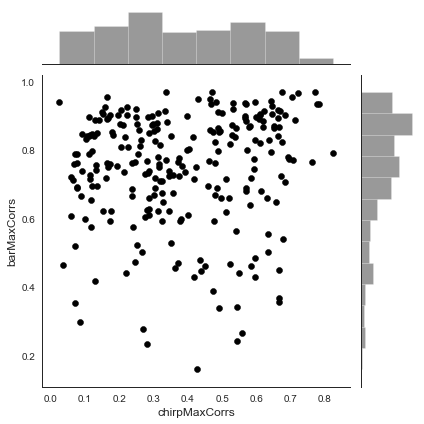

In [14]:
## Plot
# Fig pars
rcParams['figure.figsize'] = [6.0, 4.0]
sns.set_style("white") # Remove background grid

# Plot histogram
bins = np.linspace(0, 1, 50)
plt.hist(gcamp6['chirpMaxCorrs'], bins, alpha=0.5, label='Chirp')
# plt.hold(True)
plt.hist(gcamp6['barMaxCorrs'], bins, alpha=0.5, label='Bar')
plt.title('Max Correlations of gcamp6 cells to ogb1-clus for Chirp and Bar' +
          '\n (For each cell, show highest correlation)')
plt.legend()
plt.show()

# Print median correlation

# Plot scatter hist
# Note: jointplot is fig-lvl > hard to put into gridspec, needs to be positioned after plotting - check later
sns.jointplot(x=gcamp6['chirpMaxCorrs'], y=gcamp6['barMaxCorrs'], color='k')
plt.show()

# Get total cell match index (MI)
- **goal**: combine QIs and stimulus-correlations into one total match index  
  
  
- **formula**: $MI = \frac{Qi_{chirp}}{Qi_{chirp} + Qi_{bar}} * r_{chirp} + \frac{Qi_{bar}}{Qi_{chirp} + Qi_{bar}} * r_{bar}$  
  
  
     - QiChirp & QiBar: [nGcamp6Cell, 1] dimensional row vectors
     - gcamp6Ogb1RChirp & gcamp6Ogb1RBar: [nOgb1Groups, nGcamp6Cell] matrices

- **result**: MiTotal: [nOgb1Groups, nGcamp6Cell] matrix, indicating RGC cluster proximity weighted by stimulus-relative GCamp6 quality

In [15]:
# Calculate match index (MI)
chirpQiWeight = gcamp6['chirpQi'] / (gcamp6['chirpQi'] + gcamp6['barQi'])
barQiWeight = gcamp6['barQi'] / (gcamp6['barQi'] + gcamp6['chirpQi'])
mi = gcamp6['chirpCorrR'] * chirpQiWeight + gcamp6['barCorrR'] * barQiWeight

# Insert MI into df
gcamp6['mi'] = mi

gcamp6['mi'].head()

0    [0.5444097925727833, 0.5702334105807911, 0.573...
1    [-0.057607914762645714, -0.04089896546818997, ...
2    [0.7681765869639463, 0.7729515521868955, 0.631...
3    [-0.4886137576454273, -0.5091580463688758, -0....
4    [-0.3221487190091401, -0.24748152896936557, -0...
Name: mi, dtype: object

## Sort cells to groups & groups to cells by MI
- for each cell, sort groups by MI to find best match, and for each group, find best matching cell

In [16]:
# Sort groups for each cell: for each gcamp6 cell, sort ogb1 groups by MI
miSortIdxGroup = np.array(gcamp6['mi'].values.tolist()).argsort(axis=1)[:,::-1]

# Insert miSortIdx into df
gcamp6['miSortIdx'+p['groupVClu']] = pd.Series(list(miSortIdxGroup))

# Sort cells: For each ogb1 group, sort gcamp6 cells by MI
miSortIdxCell = np.array(gcamp6['mi'].values.tolist()).argsort(axis=0)[::-1]
    
# Insert miSortIdx into ogb1 dict -> for each ogb1-group, this is a list of cell indices sorted by MI
ogb1['miSortIdxCell'] = miSortIdxCell

In [17]:
# Get max mi for each cell
maxMi = np.array(gcamp6['mi'].values.tolist())\
    [np.arange(len(gcamp6)), np.array(gcamp6['miSortIdx'+p['groupVClu']].values.tolist())[:, 0]] 

# Insert maxMi into df
gcamp6['maxMi'] = pd.Series(maxMi)

## Plot distribution of max MI-values per cell [nCell]

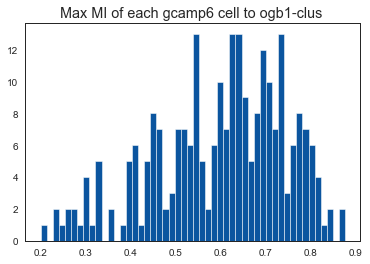

Median maxMI over all cells: 0.6244609132164461


In [18]:
# Plot
rcParams['figure.figsize'] = [6.0, 4.0]

plt.hist(maxMi, bins=50)
plt.title('Max MI of each gcamp6 cell to ogb1-clus ')
plt.show()

print('Median maxMI over all cells:', np.median(gcamp6['maxMi']))

## Apply MI-criterion to cells

In [19]:
nCellsOrig = gcamp6.index.size # original pre-criterion number of cells

# Apply percentile criterion to gcamp6 data
gcamp6 = gcamp6[gcamp6.maxMi >= np.percentile(gcamp6.maxMi, p['miCrit'])]

# Print summary
print('MI-criterion: %dth percentile (Mi = %.3f) -> keeping %d/%d cells (%d cells thrown out)' %
      (p['miCrit'], np.percentile(maxMi, p['miCrit']), gcamp6.index.size, nCellsOrig, (nCellsOrig - gcamp6.index.size)))

# Reset index to reflect new number of cells
gcamp6 = gcamp6.reset_index(drop=True)

MI-criterion: 0th percentile (Mi = 0.200) -> keeping 251/251 cells (0 cells thrown out)


# Assign GCaMP6f cells to cluster and group

In [26]:
# Get best-matching cluster for each cell
cluIdx = np.array(gcamp6['miSortIdx'+p['groupVClu']].values.tolist())[:, 0]

# Insert into df
gcamp6[p['groupVClu'].lower()+'Idx'] = pd.Series(cluIdx)

## Assign GCaMP6f cells to groups based on cluster-assignment & give IDs
- follow convention in Baden2016 of summarizing clusters into groups based on domain-knowledge (e.g. soma size and DSI)

In [27]:
if p['groupVClu'] == 'Clu':
    ## Define cluster-group mappings - extractable elsewhere?
    clu2grp = np.array([1,2,3,4,4,5,5,5,6,7,8,8,9,10,11,11,12,12,13,14,15,16,17,17,17,18,18,
                19,20,21,22,22,23,24,25,26,27,28,28,29,30,31,31,31,31,31,32,32,32], dtype=int)

    ## Bring indices into Python convention
    clu2grp -= 1 # syntax for array
    # clu2grp = [x - 1 for x in clu2grp] # syntax for list

    ## Convert cluIdx to groupIdx
    c2gIdx = [clu2grp[i] for i in np.array(gcamp6['cluIdx'])]
    # [print(i, '>', clu2grp[i]) for i in np.array(gcamp6['cluIdx'])]

    # Insert groupIdx into gcamp6
    gcamp6['groupIdx'] = c2gIdx

In [28]:
## Assign clu/groupIDs to cells
# Create RGC group IDs
groupIDs = (
    'OFF local, OS',
    'OFF DS',
    'OFF step',
    'OFF slow',
    'OFF alpha sust.',
    '(ON-)OFF "JAM-B" mix',
    'OFF sust.',
    'OFF alpha trans.',
    'OFF "mini" alpha trans.',
    'ON-OFF local-edge "W3"',
    'ON-OFF local',
    'ON-OFF DS 1',
    'ON-OFF DS 2',
    '(ON-)OFF local, OS',
    'ON step',
    'ON DS trans.',
    'ON local trans., OS',
    'ON trans.',
    'ON trans., large',
    'ON high freq.',
    'ON low freq.',
    'ON sust.',
    'ON "mini" alpha',
    'ON alpha',
    'ON DS sust. 1',
    'ON DS sust. 2',
    'ON slow',
    'ON contrast suppr.',
    'ON DS sust. 3',
    'ON local sust., OS',
    'OFF suppr. 1',
    'OFF suppr. 2',    
              )

# Assign groupIDs to cells
if p['groupVClu'] == 'Clu':
    # Convert group labels into clu IDs
    cluIDs = [groupIDs[x] for x in clu2grp]
    # Convert cluIdx to groupID and insert into df
    gcamp6['groupID'] = [cluIDs[i] for i in np.array(gcamp6['cluIdx'])]
    
elif p['groupVClu'] == 'Group':
    # Convert cluIdx to groupID and insert into df
    gcamp6['groupID'] = [groupIDs[i] for i in np.array(gcamp6['groupIdx'])]

## Plot GCaMP6f cells (sorted by total MI) against assigned OGB-1 cluster/group

In [29]:
# Avoid large figure issues
plt.close()
import gc
gc.collect()
gc.enable()

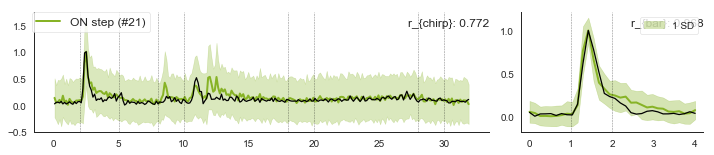

In [30]:
# Plot Parameters
cellSelect = [0, 1] # Define cells to plot [start, stop]
n = 1 # Define best n clu matches to plot
traceTypeG6 = 'DeconvMean' # Plot mean or median: 'Mean', 'Med', 'DeconvMean'
traceTypeO1 = 'DeconvMean' # Plot mean or median: 'Mean', 'Med', 'DeconvMean', 'MeanDeconv'
info = 'mini' # Add info, OPTIONS: 'full', 'mini', ''
ogb1Style = 'errArea' # OGB1 trace plot style; OPTIONS: 'average', errArea', 'auc'
gcamp6Style = 'average' # gcamp6 trace plot style; OPTIONS: 'average', errArea', 'traces'

# Figure pre-setup
rcParams['figure.figsize'] = 12, (cellSelect[1])*2.2 # workaround to adjust fig size
rcParams['lines.linewidth'] = 2
lwG6 = 1.25 # line width gcamp6f
gs = gridspec.GridSpec(cellSelect[1], 2, width_ratios=[2.5,1]) # Generate nxn grid for plotting figures
gs.update(hspace = 0.1, wspace = 0.1)
sns.set_style("white") # Remove background grid

# Color map for OGB1-groups/clusters
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=1)[::-1] # Create [n, 4] array of colors (alpha: 0.8)
cmap[:,0:3] = cmap[:,0:3]*0.7 # adjust cmap lightness (0.8)

# Plot selected gcamp6 traces with high MI and assigned ogb1-group/clu
for i in range(cellSelect[0], cellSelect[1]):
    
    # Get cell and its clu (Note: 'clu' may stand for either group or clu depending on p['groupVClu'])
    cell = np.array(np.argsort(gcamp6['maxMi'])[::-1])[i]
    clu = gcamp6[p['groupVClu'].lower()+'Idx'][np.array(np.argsort(gcamp6['maxMi'])[::-1])[i]]
    mi = np.array(np.argsort(gcamp6['maxMi'])[::-1])[i]
    
    ################################################################
    ### Left: chirp response
    stim = p['stim'][0] # for easier plotting
    plt.subplot(gs[i, 0])
    
    ################################
    ## ogb1
    # Average
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu], color=cmap[clu], # fine-tuned col
             label="{0} (#{1})".format(gcamp6['groupID'][cell], clu+1))
    # Plot ogb1 error area or fill area under avg curve
    if ogb1Style == 'errArea':
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeO1 == 'Mean') | (traceTypeO1 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeO1 == 'DeconvMean') | (traceTypeO1 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'        
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceTypeO1][:, clu] + ogb1[stim+sdTrace][:, clu],
                         ogb1[stim+traceTypeO1][:, clu] - ogb1[stim+sdTrace][:, clu],
                         edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.3)
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu],
                        edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.5)
        
    ################################
    ## gcamp6
    # Plot gcamp6 avg, avg+1SD or single traces
    if gcamp6Style == 'average':
        # Average
        sns.lineplot(y=gcamp6[stim+traceTypeG6][cell], x=ogb1[stim+'Time'], color='k', linewidth=lwG6)
    elif gcamp6Style == 'errArea':
        # Average
        sns.lineplot(y=gcamp6[stim+traceTypeG6][cell], x=ogb1[stim+'Time'], color='k', linewidth=lwG6)
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'
        plt.fill_between(ogb1[stim+'Time'],
                         gcamp6[stim+traceTypeG6][cell] + gcamp6[stim+sdTrace][cell],
                         gcamp6[stim+traceTypeG6][cell] - gcamp6[stim+sdTrace][cell],
                         edgecolor='k', facecolor='k', alpha=0.15)
    elif gcamp6Style == 'traces':
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sns.lineplot(y=gcamp6[stim+'Traces'][cell], x=ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68,
                       color='k', linewidth=lwG6)
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sns.lineplot(y=gcamp6[stim+'deconvTraces'][cell], x=ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, 
                       color='k', linewidth=lwG6)
    
    ###########
    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)    
    
    if info == 'full':
        # Title
        plt.title("cell: {0}, date: {1}, field: {2}, roi: {3}".format(
                cell,
                gcamp6['date'][cell],
                gcamp6['field'][cell],
                gcamp6['roi'][cell])+
                  "\n$QI_{chirp}: " + "{0}$".format(
                np.round(gcamp6['chirpQi'][cell], 3)),
                position=(0,1), verticalalignment='top', horizontalalignment='left', #loc='left',
                fontsize=12)
        # Legend
        plt.legend(loc=2, bbox_to_anchor=(-0.005, 0.9), borderaxespad=0, fontsize=12)
    elif info == 'mini':
#         plt.title("OGB-1 {0}: {1}".format(p['groupVClu'], clu+1)+
#                 "\n$r{chirp}$: " + "{0}".format(np.round(gcamp6[stim+'CorrR'][cell][clu], 3)),
#                  loc='left', fontsize=12)
        plt.title("\nr_{chirp}: " + "{0}".format(np.round(gcamp6[stim+'CorrR'][cell][clu], 3)),
                 fontsize=12, position=(1,1), verticalalignment='top', horizontalalignment='right') #loc='left'        
        plt.legend(loc=2, bbox_to_anchor=(-0.005, 1), borderaxespad=0, fontsize=12)
        
    # Remove axes for all plots except last one
    if (info is not 'full') & (i != cellSelect[1]-1):
        plt.axis('off') # removes only current axis so loop


    #######################################################################################        
    ### Right: bar response
    stim = p['stim'][1]
    plt.subplot(gs[i, 1])
    ################################
    ## ogb1
    # Avg
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu], color=cmap[clu]) # fine-tuned col
    # Plot ogb1 error area or fill area under avg curve
    if ogb1Style == 'errArea':
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeO1 == 'Mean') | (traceTypeO1 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeO1 == 'DeconvMean') | (traceTypeO1 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'        
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceTypeO1][:, clu] + ogb1[stim+sdTrace][:, clu],
                         ogb1[stim+traceTypeO1][:, clu] - ogb1[stim+sdTrace][:, clu],
                         edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.35, label='1 SD')
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu],
                        edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.5)
    
    ################################
    ## gcamp6
    # Plot gcamp6 avg+1SD or single traces
    if gcamp6Style == 'average':
        # Average
        sns.lineplot(y=gcamp6[stim+traceTypeG6][cell], x=ogb1[stim+'Time'], color='k', linewidth=lwG6)
    elif gcamp6Style == 'errArea':
        # Average
        sns.lineplot(y=gcamp6[stim+traceTypeG6][cell], x=ogb1[stim+'Time'], color='k', linewidth=lwG6)
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'                
        plt.fill_between(ogb1[stim+'Time'],
                         gcamp6[stim+traceTypeG6][cell] + gcamp6[stim+sdTrace][cell],
                         gcamp6[stim+traceTypeG6][cell] - gcamp6[stim+sdTrace][cell],
                         edgecolor='k', facecolor='k', alpha=0.15)
    elif gcamp6Style == 'traces':    
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sns.lineplot(y=gcamp6[stim+'Traces'][cell], x=ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, 
                       color='k', linewidth=lwG6)
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sns.lineplot(y=gcamp6[stim+'deconvTraces'][cell], x=ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, 
                       color='k', linewidth=lwG6)

    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)
    
    if info == 'full':
        # Title
        plt.title("QI_{bar}: " + "{0}".format(np.round(gcamp6['barQi'][cell], 3)), 
                  fontsize=12, position=(1,1), verticalalignment='top', horizontalalignment='right') #loc='left'
    elif info == 'mini':
        # Title
        plt.title("\nr_{bar}: " + "{0}".format(np.round(gcamp6[stim+'CorrR'][cell][clu], 3)),
                  fontsize=12, position=(1,1), verticalalignment='top', horizontalalignment='right') #loc='left'

#         # Add legend info
#         legendInfo = np.empty(shape=[n, 4])
#         legendInfo[:, 0] = clu+1 # ogb1-group ID (+1 bc python-indexing)
#         legendInfo[:, 1] = np.round(gcamp6['mi'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2)
#         legendInfo[:, 2] = np.round(gcamp6['chirpCorrR'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2)
#         legendInfo[:, 3] = np.round(gcamp6['barCorrR'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2)
#             legendInfo[:, 2] = gcamp6Ogb1PValChirp[groupSortIdxChirp[0:n, i], i] # associated p-value    
#         legend = plt.legend(legendInfo, # show R-values in legend
#                    title='OGB-1 RGC-group; MI; RChirp; RBar',
#                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=12) # prop={'size':20}
#         legend.get_title().set_fontsize('12')
    # Remove axes for all plots except last one
    if (info is not 'full') & (i != cellSelect[1]-1):
        plt.axis('off') # removes only current axis so loop
            
# Figure post-setup
# sns.plt.suptitle('GCamp6 cells sorted by high/low QI\n Left: Chirp; Right: Bar', fontsize=12) # Supertitle
if info == 'full':
    sns.plt.gca().set(
        xlabel = 'Time (s)', # info: comments can be put in line here
        ylabel = 'Fluorescence (s.d.)',
        ) # axis labels
sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.tight_layout()

# Save figure
# plt.savefig('../../results/figs/cellVcell/30-60_2.svg', dpi=1200)



# Get GCaMP6f vs OGB-1 cluster averages

Note: the usual workflow is to (1) correlate gcamp6 cells to average ogb1 **cluster**-traces, (2) assign gcamp6 cells to **clusters**, (3) convert the assignment from **cluster to group**, and (4) plot the average gcamp6 **group** against ogb1 **groups**.

Therefore, in that case we need to reload the ogb1 **group** traces.

In [31]:
# Parameters
p.update({'plotCluVGroup': 'Clu'}) # Set whether to plot groups or clus; OPTIONS: 'Group', 'Clu'

# Load/Re-load ogb1 data if necessary
if (p['groupVClu'] == 'Clu') & (p['plotCluVGroup'] == 'Group'):
    ## Load stuff
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Group'])
    print(sio.whosmat(p['loadDir']+p['fidOgb1Group'])) # Show loaded data
    p.update({'nOgb1Groups': 32})
    
    ## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) for each stimulus
    # (.mat files seem to require storage as 2D)
    for iStim in p['stim']:
        ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
        ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0]
        print(ogb1[iStim+'Dur'])    
    
    ## Add trigger times - extract flexibly later
    ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
    ogb1['barTrigTime'] = [1, 2] 
    
elif (p['groupVClu'] == 'Clu') & (p['plotCluVGroup'] == 'Clu'):
    ## Load stuff
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Clu'])
    print(sio.whosmat(p['loadDir']+p['fidOgb1Clu'])) # Show loaded data
    p.update({'nOgb1Groups': 49})
    
    ## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) for each stimulus
    # (.mat files seem to require storage as 2D)
    for iStim in p['stim']:
        ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
        ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0]
        print(ogb1[iStim+'Dur'])    
    
    ## Add trigger times - extract flexibly later
    ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
    ogb1['barTrigTime'] = [1, 2] 
elif (p['groupVClu'] == 'Group') & (p['plotCluVGroup'] == 'Group'):
    print('No need to reload')
elif (p['groupVClu'] == 'Group') & (p['plotCluVGroup'] == 'Clu'):
    print('Invalid analysis request.')

[('chirpMean', (249, 49), 'double'), ('barDeconvMean', (32, 49), 'double'), ('barMeanDeconv', (32, 49), 'double'), ('barTime', (1, 32), 'double'), ('somaSizeIdx', (49, 1), 'int64'), ('barN', (1, 49), 'int64'), ('chirpDeconvSd', (249, 49), 'double'), ('barMed', (32, 49), 'double'), ('barDeconvSd', (32, 49), 'double'), ('dsIdx', (49, 1), 'int64'), ('chirpMeanDeconv', (249, 49), 'double'), ('chirpN', (1, 49), 'int64'), ('chirpDeconvMean', (249, 49), 'double'), ('chirpTime', (1, 249), 'double'), ('barSd', (32, 49), 'double'), ('chirpMed', (249, 49), 'double'), ('barMean', (32, 49), 'double'), ('chirpSd', (249, 49), 'double')]
31.82049156626506
4.0


## Plot GCaMP6f cell cluster/group averages against OGB-1 cluster/group averages

/Users/Yannik/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/Yannik/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


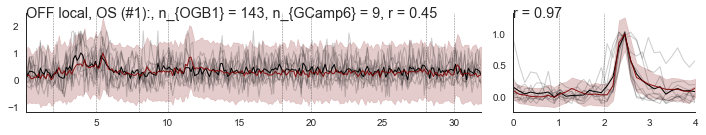

In [33]:
# NOTE: the Latex compiler seems to have issues here, maybe due to large number of figures. 
#  Text is plotted w/o latex for now
# Avoid large figure issues
plt.close()
import gc
gc.collect()

# Parameters
cluSelect = [0, 1]#p['nOgb1Groups']] # Select clusters to plot; OPTIONS: all clus: [0, p['nOgb1Groups']]
traceTypeG6 = 'DeconvMean' # Plot mean or median; OPTIONS: 'Mean', 'Median', 'DeconvMean'
traceTypeO1 = 'DeconvMean' # Plot mean or median; OPTIONS: 'Mean', 'Median', 'DeconvMean', 'MeanDeconv'
gcamp6Style = 'single' # Plot gcamp6 single traces or average; OPTIONS: 'single', 'avg'
ogb1Style = 'errArea' # OGB1 trace plot style; OPTIONS: 'errArea', 'auc'
addInfo = False # Add info or make compact plot

# Define clu depending on whether to plot clus or groups
if p['plotCluVGroup'] == 'Clu':
    clu = gcamp6.cluIdx
elif p['plotCluVGroup'] == 'Group':
    clu = gcamp6.groupIdx

# Figure pre-setup
rcParams['figure.figsize'] = 12, p['nOgb1Groups']*2 # workaround to adjust fig size
gs = gridspec.GridSpec(p['nOgb1Groups'], 2, width_ratios=[2.5,1]) # Generate nxn grid for plotting figures
gs.update(hspace = 0.1, wspace = 0.1)
sns.set_style("white") # Remove background grid (sets for all plots?)
rcParams['lines.linewidth'] = 1

# Color map
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.9)[::-1] # 0.8#Create actual [n, 4] array of colors
cmap[:,0:3] = cmap[:,0:3]*1 # adjust cmap lightness

# Initialize clu-clu mean correlation var
chirpR = np.zeros((ogb1[stim+traceTypeO1].shape[1], 2))
barR = np.zeros((ogb1[stim+traceTypeO1].shape[1], 2))

# Go through each cluster/group
for i in range(cluSelect[0], cluSelect[1]):
    #######################################################################################
    ### Left: Chirp
    
    plt.subplot(gs[i, 0])
    stim = p['stim'][0] # for easier plotting
    
    ############################
    ## GCamp6 cluster
    # Get single traces, average & SD
    traceType = traceTypeG6
    single = np.array(gcamp6[stim+traceType][clu == i].values.tolist()).T # Get single traces

    # If cluster is assigned cells, process traces
    if (single.any()):
        # Normalize traces depending on trace type
        if traceType == 'Mean':
            single = pop.normalize(single, mode='meanMax')
        elif traceType == 'Med':
            single = pop.normalize(single, mode='medMax') # Baden2016
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            single = pop.normalize(single, mode='meanR') # range-norm due to non-neg of deconv traces

        avg = np.mean(single, axis=1)
        sd = np.std(single, axis=1)
        n = single.shape[1] # n cells

    # else if cluster empty, assign line at 0
    elif (not single.any()):
        single = np.zeros(len(ogb1[stim+'Time']))
        avg = np.zeros(len(ogb1[stim+'Time']))
        sd = np.zeros(len(ogb1[stim+'Time']))
        n = 0
    
    # Plot single traces or avg
    if gcamp6Style == 'single':
        # Plot single traces
        if (traceType == 'Mean') | (traceType == 'DeconvMean'):
            sns.tsplot(single.T, time=ogb1[stim+'Time'], estimator=np.mean, err_style='unit_traces', color='k', alpha=1)
        elif traceType == 'Med':
            sns.tsplot(single.T, time=ogb1[stim+'Time'], estimator=np.median, err_style='unit_traces', color='k', alpha=1)

    elif gcamp6Style == 'avg':
        # Plot average
        sns.tsplot(avg.T, time=ogb1[stim+'Time'], color='k')
        # Plot error

        plt.fill_between(ogb1[stim+'Time'],
                         avg + sd, avg - sd,
                         edgecolor='k',
                         facecolor='k',
                         alpha=0.15,                     
                        )
    
    ###########################    
    ## OGB1 cluster
    traceType = traceTypeO1    
    # Average
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceType][:, i], color=cmap[i,:], label=traceType)
    # Plot error or area under avg curve
    if ogb1Style == 'errArea':
        
        # Error        
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceType == 'Mean') | (traceType == 'Med'):
            sdTrace = 'Sd'
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            sdTrace = 'DeconvSd'
            
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceType][:, i] + ogb1[stim+sdTrace][:, i],
                         ogb1[stim+traceType][:, i] - ogb1[stim+sdTrace][:, i],
                         edgecolor=cmap[i,:],
                         facecolor=cmap[i,:],
                         alpha=0.2, # Note: alpha specified here ignores alpha in cmap
                         label='1 SD',
                         )
        
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceType][:, i],
                        edgecolor=cmap[i], facecolor=cmap[i], alpha=0.4)
    
    #############################
    
    # Get correlation
    if (single.any()):
        chirpR[i] = scipy.stats.pearsonr(ogb1[stim+traceType][:, i], avg)
    elif (not single.any()):
        chirpR[i] = np.nan
        
    if addInfo:
        # legend
        plt.legend(title='OGB-1 '+p['groupVClu'], loc=1, bbox_to_anchor=(1, 1.25), borderaxespad=0, fontsize=12)    
    
    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)    
    
    # Title
    if p['plotCluVGroup'] == 'Clu':
        labels = cluIDs
    elif p['plotCluVGroup'] == 'Group':
        labels = groupIDs
#     plt.title('OGB-1 vs GCamp6 %s %s: #%d \n n_OGB-1 = %d, n_GCamp6 = %d' #$n_{OGB-1} = %d$,
#               %(p['groupVClu'], traceType.lower(), i+1, ogb1[stim+'N'][0,i], n)) #ogb1[stim+'N'][0,i],
#     plt.title('$n_{OGB1} = %d$, $n_{GCamp6} = %d$' % (ogb1[stim+'N'][0,i], n), loc='left')
    # Note: sames as gca().set_title(s, *args, **kwargs)
    plt.title('%s (#%d):, n_{OGB1} = %d, n_{GCamp6} = %d, r = %.2f' % \
              (labels[i], i+1, ogb1[stim+'N'][0,i], n, chirpR[i,0]), \
              position=(0,1), verticalalignment='top', horizontalalignment='left')#loc='left')
    
    # Remove axes for all plots except last one
    if (not addInfo) & (i != cluSelect[1]-1):
        plt.axis('off') # removes only current axis so loop
    
    #######################################################################################
    ### Right: bar
    plt.subplot(gs[i, 1])
    stim = p['stim'][1] # for easier plotting

    
    ############################
    ## GCamp6 cluster
    # Get single traces, average & SD
    traceType = traceTypeG6
    single = np.array(gcamp6[stim+traceType][clu == i].values.tolist()).T # Get single traces

    # If cluster is assigned cells, process traces
    if (single.any()):
        # Normalize traces depending on trace type
        if traceType == 'Mean':
            single = pop.normalize(single, mode='meanMax')
        elif traceType == 'Med':
            single = pop.normalize(single, mode='medMax') # Baden2016
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            single = pop.normalize(single, mode='meanR') # range-norm due to non-neg of deconv traces

        avg = np.mean(single, axis=1)
        sd = np.std(single, axis=1)
        n = single.shape[1] # n cells
        
    # else if cluster empty, assign line at 0
    elif (not single.any()):
        single = np.zeros(len(ogb1[stim+'Time']))
        avg = np.zeros(len(ogb1[stim+'Time']))
        sd = np.zeros(len(ogb1[stim+'Time']))
        n = 0
    
    # Plot single traces or avg
    if gcamp6Style == 'single':
        # Plot single traces
        if (traceType == 'Mean') | (traceType == 'DeconvMean'):
            sns.tsplot(single.T, time=ogb1[stim+'Time'], estimator=np.mean, err_style='unit_traces', color='k',
                       alpha=1)
        elif traceType == 'Med':
            sns.tsplot(single.T, time=ogb1[stim+'Time'], estimator=np.median, err_style='unit_traces', color='k', 
                       alpha=1)

    elif gcamp6Style == 'avg':
        # Plot average
        sns.tsplot(avg.T, time=ogb1[stim+'Time'], color='k')
        # Plot error
        plt.fill_between(ogb1[stim+'Time'],
                         avg + sd, avg - sd,
                         edgecolor='k',
                         facecolor='k',
                         alpha=0.15,                     
                        )
    
    ############################
    ## OGB1-cluster
    traceType = traceTypeO1    
    # Average
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceType][:, i],            
             color=cmap[i,:],
             label=traceType)
    # Plot error or area under avg curve
    if ogb1Style == 'errArea':
        
        # Error        
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceType == 'Mean') | (traceType == 'Med'):
            sdTrace = 'Sd'
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            sdTrace = 'DeconvSd'
            
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceType][:, i] + ogb1[stim+sdTrace][:, i],
                         ogb1[stim+traceType][:, i] - ogb1[stim+sdTrace][:, i],
                         edgecolor=cmap[i,:],
                         facecolor=cmap[i,:],
                         alpha=0.2,
                         label='1 SD',
                         )
        
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceType][:, i],
                        edgecolor=cmap[i], facecolor=cmap[i], alpha=0.4)
    
    ############################
    # Get correlation
    if (single.any()):
        barR[i] = scipy.stats.pearsonr(ogb1[stim+traceType][:, i], avg)
    elif (not single.any()):
        barR[i] = np.nan
        
    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)    
    
    # Bar stim title
    plt.title('r = %.2f' % (barR[i,0]), position=(0,1), \
              verticalalignment='top', horizontalalignment='left')#loc='left'

    # Remove axes for all plots except last one
    if (not addInfo) & (i != cluSelect[1]-1):
        plt.axis('off') # removes only current axis so loop        

# Figure post-setup
# sns.plt.suptitle('GCamp6 cells sorted by high/low QI\n Left: Chirp; Right: Bar', fontsize=12) # Supertitle
if addInfo:
    sns.plt.gca().set(
        xlabel = 'Time (s)', # info: comments can be put in line here
        ylabel = 'Fluorescence (s.d.)',
        ) # axis labels
sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.tight_layout()
# plt.savefig('../../results/figs/cluVclu/kern_7.8Hz.svg', dpi=1200)

# plt.close()

### Get mean and median correlation between OGB-1 and GCaMP6f clusters
- NOTE: this is just the quick way of teasing the info out of the plot cell above. The plot cell is currently too complex, and instead there will be a separate analysis cell before, from which the plotting cell just gets the data

In [34]:
print('cluster average trace correlations:')
print('mean_chirp:\t', np.nanmean(chirpR[:,0]))
print('median_chirp:\t', np.nanmedian(chirpR[:,0]))

print('mean_bar:\t', np.nanmean(barR[:,0]))
print('median_bar:\t', np.nanmedian(barR[:,0]))

cluster average trace correlations:
mean_chirp:	 0.00910802749142113
median_chirp:	 0.0
mean_bar:	 0.019740168977295653
median_bar:	 0.0


## Get gcamp6 and ogb1 cluster correlations / match
 - use MI as simple proxy instead of correlating mean traces

In [35]:
# Define clu depending on whether to plot clus or groups
if p['plotCluVGroup'] == 'Clu':
    clu = gcamp6.cluIdx
elif p['plotCluVGroup'] == 'Group':
    clu = gcamp6.groupIdx
    
meanMi = np.zeros((p['nOgb1Groups'], ), dtype=float) # Initialize
for i in range(p['nOgb1Groups']):
    meanMi[i] = np.mean(gcamp6.maxMi[clu == i])

print('meanMi:', meanMi)

meanMiTot = np.nanmean(meanMi)
print('meanMiTot:', meanMiTot)

meanMi: [0.67  0.72  0.644 0.511 0.612 0.513   nan 0.582   nan 0.613 0.581 0.649
 0.763   nan 0.434 0.651 0.639 0.516   nan   nan 0.671 0.351 0.569 0.592
 0.849 0.662 0.611 0.703 0.625 0.778   nan 0.561 0.807 0.633 0.649 0.562
 0.632 0.485 0.446   nan   nan   nan 0.522   nan 0.598 0.636 0.562 0.502
 0.469]
meanMiTot: 0.6044884894308883


# Get number of cells per cluster/group

Note on alternatives tested:
 - sns.countplot(gcamp6['cluIdx']) # ignores clusters w zero counts
 - gcamp6['cluIdx'].value_counts() # ignores clusters w zero counts

In [36]:
# Set whether to plot groups or clus
p.update({'plotCluVGroup': 'Group'}) # OPTIONS: 'Group', 'Clu'

# Load/Re-load ogb1 data if necessary
if (p['groupVClu'] == 'Clu') & (p['plotCluVGroup'] == 'Group'):
    ## Load stuff
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Group'])
    print(sio.whosmat(p['loadDir']+p['fidOgb1Group'])) # Show loaded data
    p.update({'nOgb1Groups': 32})
    
    ## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) for each stimulus
    # (.mat files seem to require storage as 2D)
    for iStim in p['stim']:
        ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
        ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0]
        print(ogb1[iStim+'Dur'])    
    
    ## Add trigger times - extract flexibly later
    ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
    ogb1['barTrigTime'] = [1, 2] 
    
elif (p['groupVClu'] == 'Clu') & (p['plotCluVGroup'] == 'Clu'):
    ## Load stuff
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Clu'])
    print(sio.whosmat(p['loadDir']+p['fidOgb1Clu'])) # Show loaded data
    p.update({'nOgb1Groups': 49})
    
    ## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) for each stimulus
    # (.mat files seem to require storage as 2D)
    for iStim in p['stim']:
        ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
        ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0]
        print(ogb1[iStim+'Dur'])    
    
    ## Add trigger times - extract flexibly later
    ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
    ogb1['barTrigTime'] = [1, 2] 
elif (p['groupVClu'] == 'Group') & (p['plotCluVGroup'] == 'Group'):
    print('No need to reload')
elif (p['groupVClu'] == 'Group') & (p['plotCluVGroup'] == 'Clu'):
    print('Invalid analysis request.')

# Reconf color map
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.8)[::-1] # Create actual [n, 4] array of colors
cmap[:,0:3] = cmap[:,0:3]*0.8 # adjust cmap lightness    

[('chirpMean', (249, 32), 'double'), ('chirpMed', (249, 32), 'double'), ('chirpSd', (249, 32), 'double'), ('chirpDeconvMean', (249, 32), 'double'), ('chirpDeconvSd', (249, 32), 'double'), ('chirpTime', (1, 249), 'double'), ('chirpN', (1, 32), 'int64'), ('barMean', (32, 32), 'double'), ('barMed', (32, 32), 'double'), ('barSd', (32, 32), 'double'), ('barDeconvMean', (32, 32), 'double'), ('barDeconvSd', (32, 32), 'double'), ('barTime', (1, 32), 'double'), ('barN', (1, 32), 'int64')]
31.82049156626506
4.0


In [37]:
## Get Gcamp6 cells per cluster/group

# Define clu depending on whether to plot clus or groups
if p['plotCluVGroup'] == 'Clu':
    clu = gcamp6.cluIdx
elif p['plotCluVGroup'] == 'Group':
    clu = gcamp6.groupIdx

cells_per_clu = np.zeros((p['nOgb1Groups'], ), dtype=int) # Initialize
for i in range(p['nOgb1Groups']):
    cells_per_clu[i] = len(gcamp6[clu == i])
print('cells_per_clu gcamp6:\n', cells_per_clu)
print('nCells gcamp6:', sum(cells_per_clu))

# Get gcamp6f cell percentage per cluster
cells_per_clu_g6_perc = pop.percentage(cells_per_clu, sum(cells_per_clu))
print('Check if percentages add up to 100: %.6f' %sum(cells_per_clu_g6_perc))

# Get nClus with nCells > x
min_cpc = 1
print('N clusters with less than %i cell(s): %i' % (min_cpc, np.shape(cells_per_clu[cells_per_clu > min_cpc])[0]))

cells_per_clu gcamp6:
 [ 9  7 10  5 14  0  5 14  5  0 10 10  0  0  9  2 18 21  5 10  5  5  3  7
  1  1  4  9  0  0  4 58]
nCells gcamp6: 251
Check if percentages add up to 100: 100.000000
Number of clusters with less than 1 cell(s): 24


In [38]:
# Get OGB1 cell percentage per cluster
cells_per_clu_o1_perc = pop.percentage(ogb1['chirpN'][0], sum(ogb1['chirpN'][0]))

In [39]:
# Make cells_per_clu into df
cpc = pd.DataFrame({
    'groupIdx': np.arange(p['nOgb1Groups']), 
    'g6_perc':  cells_per_clu_g6_perc,
    'g6_n':     cells_per_clu,
    'o1_perc':  cells_per_clu_o1_perc,
    'o1_n':     ogb1['chirpN'][0],
    'color': pd.Series(list(cmap)),
    })
#     columns = ['g6_perc', 'o1_perc'])

# Bring some data from 'wide' into 'long' format for some plots
cpc2 = pd.melt(cpc, id_vars=['groupIdx', 'color'], value_vars=['g6_perc', 'o1_perc'],
        var_name='dataset', value_name='cpc_perc')

## Plot cells per clu/group
Grouped bar plot

In [41]:
plt.close()
import gc
gc.collect()

5610

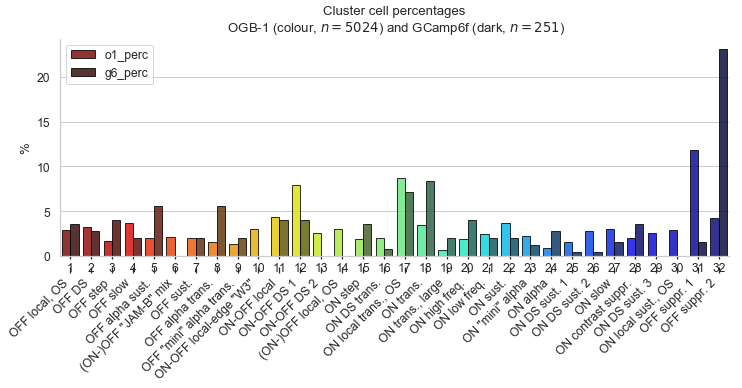

In [42]:
# Figure setup
rcParams['figure.figsize'] = [8.0, 8.0]
sns.set(style="whitegrid", font_scale=1.1)
fig, ax = plt.subplots(figsize=(12,4))

# Color map for OGB1-groups/clusters - define plot-wise for better control
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.7)[::-1] # Create  [n, 4] array of colors (alpha: 0.8)
cmap[:,0:3] = cmap[:,0:3]*0.9 # adjust cmap lightness (0.8)

sns.barplot(data=cpc2, x='groupIdx', y='cpc_perc', 
            hue='dataset', hue_order=['o1_perc', 'g6_perc'], edgecolor='k', linewidth=1, alpha=0.8) 
# Figure post-setup
ax.set(
    title = 'Cluster cell percentages'\
            '\n OGB-1 (colour, $n=%d$) and GCamp6f (dark, $n=%d$)'
            %(sum(ogb1['chirpN'][0]), len(gcamp6)),
    xlabel = '',
    ylabel = '%',
#     xticks = np.arange(4, p['nOgb1Groups'], 5), # Note: tick 4 > ticklabel 5
#     xticklabels = np.arange(5, p['nOgb1Groups'], 5), # Note: need to set this too to align ticks and ticklabels!
    xticklabels = np.arange(1, p['nOgb1Groups']+1, 1), # Note: need to set this too to align ticks and ticklabels!
    )
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax.tick_params(axis='x', which='major', length=3.) # sns.set_style({'xtick.major.size':'0.0'})
ax.tick_params(axis='x', which='minor', length=2.)

## Change grouped barplot bar colors
# A bit of a trick that requires a colormap spanning both gcamp6 and ogb1 groups
# and applies each color to a single bar patch object
cmapDark = cmap*0.4+[0,0,0,0.4]
cmap2 = np.concatenate((cmap,cmapDark))
for j, bar in enumerate(ax.patches):
    bar.set_color(cmap2[j,:])
    bar.set_edgecolor([0,0,0,1])
    
plt.legend(loc=0)

## Add 2nd axis with clu/group labels
# Use clu or group labels
if p['plotCluVGroup'] == 'Clu':
    labels = cluIDs
elif p['plotCluVGroup'] == 'Group':
    labels = groupIDs
ax2 = ax.twiny() # Create twin axis
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes',-0.05)) # Offset ax2
ax2.set_frame_on(False)
ax2.set(
    xlim = ax.get_xlim(), # Align ax2 and ax x-axis (important)
    xticks = ax.get_xticks(),
    xticklabels = labels,
    )
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax2.grid(False)

# Figure post setup
sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.show()

# Save figure
# plt.savefig('../../results/figs/cells_per_cluGroup/cpc_g6_only.eps', dpi=1200)

## Binomial test of cell-per-cluster/group significance

In [50]:
p['alpha'] = 0.01 # Significance lvl

pvals = np.zeros(len(cpc['g6_perc']))

for i, val in enumerate(cpc['g6_n']):
    prob = cpc['o1_perc'][i]*0.01
#     print(i, val, prob)
    pvals[i] = stats.binom_test(val, 251, prob, alternative='two-sided')
    
print(pvals)

[0.445 0.858 0.012 0.18  0.001 0.012 1.    0.    0.4   0.001 1.    0.019
 0.002 0.001 0.064 0.252 0.434 0.    0.036 0.031 0.838 0.234 0.389 0.007
 0.195 0.012 0.264 0.105 0.002 0.002 0.    0.   ]


In [51]:
## Correct for multiple comparisons using False Discovery Rate (FDR)

import statsmodels.stats.multitest as smm

[reject_null, pvals_corr, _, _] = smm.multipletests(pvals, p['alpha'], method='fdr_bh') # FDR-Benjamini/Hochberg
print(reject_null)
print(pvals_corr)

# # Add to df
cpc = cpc.assign(g6_pval_corr=pvals_corr)
cpc = cpc.assign(g6_signif_corr=reject_null)

[False False False False  True False False  True False  True False False
  True  True False False False  True False False False False False False
 False False False False  True  True  True  True]
[0.508 0.915 0.028 0.289 0.005 0.028 1.    0.001 0.492 0.005 1.    0.04
 0.008 0.005 0.114 0.351 0.508 0.001 0.067 0.061 0.915 0.34  0.492 0.021
 0.297 0.028 0.352 0.177 0.008 0.007 0.    0.   ]


## Get number of cells per cluster in GCaMP6f vs OFB-1 data as log2 ratios

In [54]:
## Regularize cell counts using additive / Laplace smoothing
# This is done here to avoid -inf values for gcamp6f clusters that did not get any cells assigned

def additive_smoothing(x, k=1):
    """Smoothes categorical data x by adding a pseudocount k and normalizing by n+k.
    INPUT:
    x : ndarray : Array of counts per category.
    k : scalar : Pseudocount. [DEFAULT: 1]
    
    OUTPUT:
    x_smooth : ndarray : Smoothed array.
    """
    k = 1 # Pseudocount k > 0
    x_smooth = (x + k) / (sum(x)+k)
    
    return x_smooth

In [55]:
# Smooth cell counts
cells_per_clu_g6_perc_smooth = additive_smoothing(cells_per_clu)*100 # Multiply by 100 to get percentage
cells_per_clu_o1_perc_smooth = additive_smoothing(ogb1['chirpN'][0])*100

In [62]:
# Also get Log2 ratio of gcamp6f vs ogb-1 cell percentages per cluster
cpc_perc_log2 = np.log2(cells_per_clu_g6_perc_smooth / cells_per_clu_o1_perc_smooth)
cpc = cpc.assign(log2=cpc_perc_log2) # Add log2 ratios to df

## Plot cell distribution log2 ratios

In [58]:
rcParams['figure.autolayout'] = True

No handles with labels found to put in legend.
/Users/Yannik/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


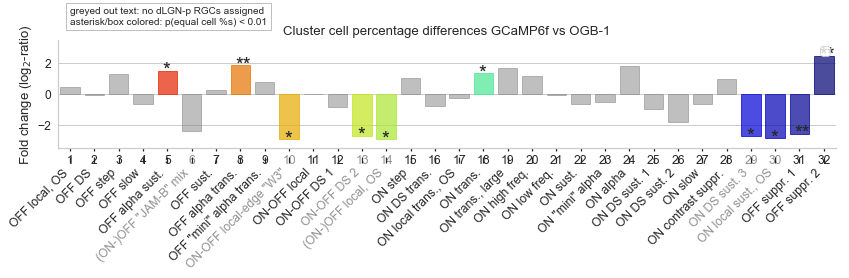

In [59]:
# Figure pars
p['doOwnCmap'] = True

# Figure setup
rcParams['figure.figsize'] = [8.0, 8.0]
sns.set(style="whitegrid", font_scale=1.1)
fig, ax = plt.subplots(figsize=(12,4))

# Color map for OGB1-groups/clusters - define plot-wise for better control
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.7)[::-1] # Create  [n, 4] array of colors (alpha: 0.8)
cmap[:,0:3] = cmap[:,0:3]*0.9 # adjust cmap lightness (0.8)

sns.barplot(data=cpc, x='groupIdx', y='log2', palette="Spectral")#, linewidth=1, edgecolor='k')

# Figure post-setup
ax.set(
    title = 'Cluster cell percentage differences GCaMP6f vs OGB-1',
    xlabel = '',
    ylabel = 'Fold change (log$_2$-ratio)' , #\n($log_2$(%dLGN-p RGCs/%RGC pop.))',
#     xticks = np.arange(4, p['nOgb1Groups'], 5), # Note: tick 4 > ticklabel 5
#     xticklabels = np.arange(5, p['nOgb1Groups'], 5), # Note: need to set this too to align ticks and ticklabels!
    xticklabels = np.arange(1, p['nOgb1Groups']+1, 1), # Note: need to set this too to align ticks and ticklabels!
    )
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax.tick_params(axis='x', which='major', length=3.) # sns.set_style({'xtick.major.size':'0.0'})
ax.tick_params(axis='x', which='minor', length=2.)
ax.tick_params(axis='y', which='major', length=3.)
ax.tick_params(axis='y', which='minor', length=2.)
ax.set_ylim([-3.5, 3.5])


# Change barplot bar colors
if p['doOwnCmap'] == True:
    # A bit of a trick that requires a colormap spanning both gcamp6 and ogb1 groups
    # and applies each color to a single bar patch object
    cmapDark = cmap*0.4+[0,0,0,0.4]
    cmap2 = np.concatenate((cmap,cmapDark))
    for j, bar in enumerate(ax.patches):
        bar.set_color(cmap2[j,:])
#         bar.set_edgecolor([0,0,0,1])
    
plt.legend(loc=0)

## Add 2nd axis with clu/group labels
# Use clu or group labels
if p['plotCluVGroup'] == 'Clu':
    labels = cluIDs
elif p['plotCluVGroup'] == 'Group':
    labels = groupIDs
ax2 = ax.twiny() # Create twin axis
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes',-0.08)) # Offset ax2
ax2.set_frame_on(False)
ax2.set(
    xlim = ax.get_xlim(), # Align ax2 and ax x-axis (important)
    xticks = ax.get_xticks(),
    xticklabels = labels,
    )
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax2.grid(False)

## Mark clusters w no assigned gcamp6f cells: mark ticks transparent
for i,t in enumerate(ax.xaxis.get_ticklabels()): # mark numbers
    if cpc.g6_n[i] == 0:
        t.set_alpha(0.5)
        
for i,t in enumerate(ax2.xaxis.get_ticklabels()): # mark labels
    if cpc.g6_n[i] == 0:
        t.set_alpha(0.5)        
        
## Mark clusters w n=1 assigned cells
# for j, bar in enumerate(ax.patches):
#     if cpc['g6_n'][j] == 1:
#         ax.text(bar.get_x()+0.15, bar.get_y()+0.15, 'n = 1', 
#                 fontsize=10, horizontalalignment='left', verticalalignment='bottom', rotation=90)
        
## Mark significant g6 vs o1 differences
# for i,t in enumerate(ax.xaxis.get_ticklabels()): # mark numbers
#     if cpc.g6_signif[i] == 1:
#         t.set_color('red')
        
for i,bar in enumerate(ax.patches):
    # Adjust significance marker depending on lvl
    if cpc.g6_pval_corr[i] <= p['alpha']:
        txt = '*'
    if cpc.g6_pval_corr[i] <= p['alpha']/10:
        txt = '**'
    
    if (cpc.g6_signif_corr[i] == 1) & (np.isinf(cpc_perc_log2[i])): # set * at x-axis for clusters with no cells
        ax.text(bar.get_x()+0.2, ax.get_ylim()[0], txt, # y:-3.6
                fontsize=20, horizontalalignment='left', verticalalignment='center')
#         if np.isinf(cpc_perc_log2[i]):
#             bar.set_linewidth(1)
    elif (cpc.g6_signif_corr[i] == 1) & (not np.isinf(cpc_perc_log2[i])): #g6_pval_corr
        if bar.get_y() >= 0:
            ax.text(bar.get_x()+0.2, bar.get_y()+bar.get_height(), txt, # y:-3.6
                    fontsize=20, horizontalalignment='left', verticalalignment='center')
        else:
            ax.text(bar.get_x()+0.2, bar.get_y()-0.7, txt, # y:-3.6
                    fontsize=20, horizontalalignment='left', verticalalignment='center')
    elif cpc.g6_signif_corr[i] == 0:
        bar.set_color('grey')
        bar.set_alpha(0.5)
#         bar.set_edgecolor('grey')

# Add info text
ax.text(0, 4.55, 
        'greyed out text: no dLGN-p RGCs assigned'\
#         '\nn=1: one cell assigned'\
        '\nasterisk/box colored: p(equal cell %s) < 0.01',
        fontsize=10, bbox={'facecolor':'white', 'edgecolor':'grey', 'alpha':0.5})
# ax.text(0, 3.8, 'n=1: one cell assigned', fontsize=10)
# ax.text(0, 3.1, 'asterisk: p(equal cell proportions) < 0.01', fontsize=10)

sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.show()

# plt.tight_layout()

# Save figure
# plt.savefig('../../results/figs/cellPerCluGroup/cpc_kern_7.8Hz_log2.pdf', dpi=1200)

# Export gcamp6 data
Exports gcamp6 pandas dataframe (pd df) in various formats

In [71]:
# Save as pickled object
print('Saving to:', p['saveDir']+'dlgn-p_rgc_assigned.pkl')
gcamp6.to_pickle(p['saveDir']+'dlgn-p_rgc_assigned.pkl')

Saving to: ../../data/2P/proc/dlgn-p_rgc_assigned.pkl


In [66]:
## Export gcamp6f data to MATLAB
# Exports gcamp6f pandas dataframe (pd df) as .mat to MATLAB. Use workaround of converting df to dict before using scipy.io
# Convert pd df to dict

# Create [cell, time] array rather than single cells for each cell
g6_dict = {col_name : np.array(gcamp6[col_name].values.tolist()) for col_name in gcamp6.columns.values}

# Save dict
print('Saving to:', p['saveDir']+p['fidGcamp6Save'])
sio.savemat(p['saveDir']+p['fidGcamp6Save'], g6_dict) # Just save dict (> more crowded workspace)

In [68]:
# Inspect saved var
viewData = sio.whosmat(p['saveDir']+p['fidGcamp6Save'])
viewData

[('chirpDeconvMean', (251, 249), 'double'),
 ('chirpDeconvSd', (251, 249), 'double'),
 ('chirpDeconvTraces', (1, 251), 'cell'),
 ('chirpMean', (251, 249), 'double'),
 ('chirpMed', (251, 249), 'double'),
 ('chirpQi', (1, 251), 'double'),
 ('chirpSd', (251, 249), 'double'),
 ('chirpTraces', (1, 251), 'cell'),
 ('date', (251,), 'char'),
 ('field', (251,), 'char'),
 ('roi', (1, 251), 'double'),
 ('somaArea', (1, 251), 'double'),
 ('barCondAvgTraces', (251, 8, 32), 'double'),
 ('barDeconvMean', (251, 32), 'double'),
 ('barDeconvSd', (251, 32), 'double'),
 ('barDeconvTraces', (251, 24, 32), 'double'),
 ('barMean', (251, 32), 'double'),
 ('barMed', (251, 32), 'double'),
 ('barQi', (1, 251), 'double'),
 ('barSd', (251, 32), 'double'),
 ('barTraces', (251, 24, 32), 'double'),
 ('dsPVal', (1, 251), 'double'),
 ('dsVector', (251, 8), 'double'),
 ('dsi', (1, 251), 'double'),
 ('chirpQiSortIdx', (1, 251), 'int64'),
 ('barQiSortIdx', (1, 251), 'int64'),
 ('chirpCorrR', (251, 49), 'double'),
 ('barCo

# Supplemental analysis

## Count number of recorded fields, cells and cells per field

In [69]:
nFieldsTot = 0 # Total nFields counter

for i in np.unique(gcamp6.date):
    print('date:', i)
    
    nFields = len(np.unique(gcamp6.field[gcamp6.date == i]))
    print(' nFields:', nFields)
    nFieldsTot += nFields
    
    nCells = len(gcamp6.roi[(gcamp6.date == i)])
    print(' nCells:', nCells)
    
    # nCells over all fields in date i
    nCellsPerField = nCells/nFields
    print(' nCellsPerField: %.1f' % np.round(nCellsPerField,1))
    
    # nCells for each field
#     for x in np.unique(gcamp6.field[gcamp6.date == i]):
#         cellsInField = len(gcamp6.roi[(gcamp6.date == i) & (gcamp6.field == x)])
#         print('  f%s: n=%i' % (x, cellsInField))
    
print('\nTotal nFields:', nFieldsTot)
print('Total nCells:', len(gcamp6))
print('Total nCellsPerField:', np.round(len(gcamp6)/nFieldsTot, 1))

date: 20160223
 nFields: 15
 nCells: 62
 nCellsPerField: 4.1
date: 20160224
 nFields: 12
 nCells: 34
 nCellsPerField: 2.8
date: 20160420
 nFields: 16
 nCells: 23
 nCellsPerField: 1.4
date: 20160421
 nFields: 25
 nCells: 132
 nCellsPerField: 5.3

Total nFields: 68
Total nCells: 251
Total nCellsPerField: 3.7
